Выполнил Железнов Илья  
М8О-310Б-22

In [223]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Подключаем два датасета:
* *test.csv*  - тестовая выборка, на которой будем тестировать модель
* *train.csv* - то на чем мы будем обучать модель

И для того, чтобы убедиться, что все хорошо, поглядим **train_data** и размер **test_data**:

In [224]:
train_data = pd.read_csv('src/train.csv')
test_data = pd.read_csv('src/test.csv')

print(f"Размер test_data: {test_data.shape}")
train_data.head()

Размер test_data: (5000, 36)


,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,...,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2010-06-26,27.0,66829.0,549.0,17290.0,60.0,Divorced,1.0,Rent,1095.0,...,Employed,Associate,4.0,35067.0,0.257790,0.251465,508.970230,0.288013,0.0,66.176500
1,1996-09-23,55.0,172147.0,850.0,16110.0,36.0,Widowed,1.0,Mortgage,211.0,...,Employed,High School,33.0,27001.0,0.086110,0.093173,514.675859,0.050585,1.0,28.495737
2,2015-01-19,51.0,300000.0,850.0,38436.0,36.0,Married,0.0,Mortgage,546.0,...,Employed,Bachelor,28.0,278382.0,0.108436,0.115443,1268.276385,0.072571,1.0,34.488104
3,1981-05-12,25.0,34683.0,847.0,19186.0,48.0,Married,0.0,Other,153.0,...,Employed,High School,0.0,9224.0,0.100686,0.112822,498.505187,0.225415,1.0,36.910753
4,1995-05-07,55.0,300000.0,850.0,30437.0,48.0,Single,2.0,Rent,562.0,...,Employed,Bachelor,31.0,4502.0,0.110437,0.089037,756.035156,0.052721,1.0,31.347091


Изучив колонки и содержимое входных данных, пришел к выводу, что нам нужно:
* распарсить дату из колонки *ApplicationDate*, т.к. это строка, а нам нужны числа
* при помощи one-hot enconding преобразовать категориальные переменные в числа 
* найти пустые значения и дубликаты в таблице и обработать их

# Обработка таблицы
## Парсинг даты

In [225]:
# Преобразуем колонку ApplicationDate в формат datetime
train_data['ApplicationDate'] = pd.to_datetime(train_data['ApplicationDate'], format='%Y-%m-%d')
test_data['ApplicationDate'] = pd.to_datetime(test_data['ApplicationDate'], format='%Y-%m-%d')

# Извлечение года, месяца и дня
train_data['ApplicationYear'] = train_data['ApplicationDate'].dt.year
train_data['ApplicationMonth'] = train_data['ApplicationDate'].dt.month
train_data['ApplicationDay'] = train_data['ApplicationDate'].dt.day

test_data['ApplicationYear'] = test_data['ApplicationDate'].dt.year
test_data['ApplicationMonth'] = test_data['ApplicationDate'].dt.month
test_data['ApplicationDay'] = test_data['ApplicationDate'].dt.day

# Удаляем старый столбец с датой
train_data.drop(columns=['ApplicationDate'], inplace=True)
test_data.drop(columns=['ApplicationDate'], inplace=True)

# Удостоверимся в проделанной работе
train_data.head()


,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,CreditCardUtilizationRate,...,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore,ApplicationYear,ApplicationMonth,ApplicationDay
0,27.0,66829.0,549.0,17290.0,60.0,Divorced,1.0,Rent,1095.0,0.151985,...,35067.0,0.257790,0.251465,508.970230,0.288013,0.0,66.176500,2010.0,6.0,26.0
1,55.0,172147.0,850.0,16110.0,36.0,Widowed,1.0,Mortgage,211.0,0.175693,...,27001.0,0.086110,0.093173,514.675859,0.050585,1.0,28.495737,1996.0,9.0,23.0
2,51.0,300000.0,850.0,38436.0,36.0,Married,0.0,Mortgage,546.0,0.444605,...,278382.0,0.108436,0.115443,1268.276385,0.072571,1.0,34.488104,2015.0,1.0,19.0
3,25.0,34683.0,847.0,19186.0,48.0,Married,0.0,Other,153.0,0.188452,...,9224.0,0.100686,0.112822,498.505187,0.225415,1.0,36.910753,1981.0,5.0,12.0
4,55.0,300000.0,850.0,30437.0,48.0,Single,2.0,Rent,562.0,0.273431,...,4502.0,0.110437,0.089037,756.035156,0.052721,1.0,31.347091,1995.0,5.0,7.0


## Преобразование категориальных переменных

Сначала найдем те колонки, которые содержат наши категориальные данные:

In [226]:
print("Категориальные столбцы в train_data:\n", train_data.select_dtypes(include=['object']).columns)

Категориальные столбцы в train_data:
 Index(['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose',
       'EmploymentStatus', 'EducationLevel'],
      dtype='object')


Используя функцию из **pandas** - *get_dummies* преобразуем наши данные в двух таблицах

In [227]:
train_data = pd.get_dummies(train_data, columns=['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel'], drop_first=True)
test_data = pd.get_dummies(test_data, columns=['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel'], drop_first=True)

#убедимся в том, что все выполнилось верно
train_data.head()

,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,NumberOfDependents,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,...,LoanPurpose_Debt Consolidation,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other,EmploymentStatus_Self-Employed,EmploymentStatus_Unemployed,EducationLevel_Bachelor,EducationLevel_Doctorate,EducationLevel_High School,EducationLevel_Master
0,27.0,66829.0,549.0,17290.0,60.0,1.0,1095.0,0.151985,2.0,1.0,...,False,True,False,False,False,False,False,False,False,False
1,55.0,172147.0,850.0,16110.0,36.0,1.0,211.0,0.175693,3.0,0.0,...,False,False,True,False,False,False,False,False,True,False
2,51.0,300000.0,850.0,38436.0,36.0,0.0,546.0,0.444605,3.0,0.0,...,False,True,False,False,False,False,True,False,False,False
3,25.0,34683.0,847.0,19186.0,48.0,0.0,153.0,0.188452,7.0,0.0,...,True,False,False,False,False,False,False,False,True,False
4,55.0,300000.0,850.0,30437.0,48.0,2.0,562.0,0.273431,3.0,1.0,...,True,False,False,False,False,False,True,False,False,False


## Дубликаты и пропуски


In [228]:
# Проверка на наличие пропусков в данных
train_data.isnull().sum()

Age                                530
AnnualIncome                       530
CreditScore                       1031
LoanAmount                        1031
LoanDuration                       530
NumberOfDependents                 530
MonthlyDebtPayments               1031
CreditCardUtilizationRate          530
NumberOfOpenCreditLines            530
NumberOfCreditInquiries            530
DebtToIncomeRatio                  530
BankruptcyHistory                 1031
PreviousLoanDefaults               530
PaymentHistory                     530
LengthOfCreditHistory              530
SavingsAccountBalance              530
CheckingAccountBalance            1031
TotalAssets                       1031
TotalLiabilities                   530
MonthlyIncome                      530
UtilityBillsPaymentHistory         530
JobTenure                          530
Experience                         530
NetWorth                          1031
BaseInterestRate                  1031
InterestRate             

Так как мы имеем несколько возможных путей к обработки пропусков, я решил выбрать удаление пропусков, так как их
не очень много. Удалять столбцы нам не надо, так не было выявлено столбцов, где их количество сильно превышает самих значений.

In [229]:
train_data = train_data.dropna()

print(train_data.isnull().sum())

Age                               0
AnnualIncome                      0
CreditScore                       0
LoanAmount                        0
LoanDuration                      0
NumberOfDependents                0
MonthlyDebtPayments               0
CreditCardUtilizationRate         0
NumberOfOpenCreditLines           0
NumberOfCreditInquiries           0
DebtToIncomeRatio                 0
BankruptcyHistory                 0
PreviousLoanDefaults              0
PaymentHistory                    0
LengthOfCreditHistory             0
SavingsAccountBalance             0
CheckingAccountBalance            0
TotalAssets                       0
TotalLiabilities                  0
MonthlyIncome                     0
UtilityBillsPaymentHistory        0
JobTenure                         0
Experience                        0
NetWorth                          0
BaseInterestRate                  0
InterestRate                      0
MonthlyLoanPayment                0
TotalDebtToIncomeRatio      

In [230]:
# Проверка на дубликаты
print(f"\nКоличество дубликатов до: {train_data.duplicated().sum()}")

train_data.drop_duplicates(inplace=True)

print(f"\nКоличество дубликатов после: {train_data.duplicated().sum()}")


Количество дубликатов до: 457

Количество дубликатов после: 0


# Поиск и обработка корреляций 

Построим корреляционную матрицу и отобразим ее в виде *HeatMap*:

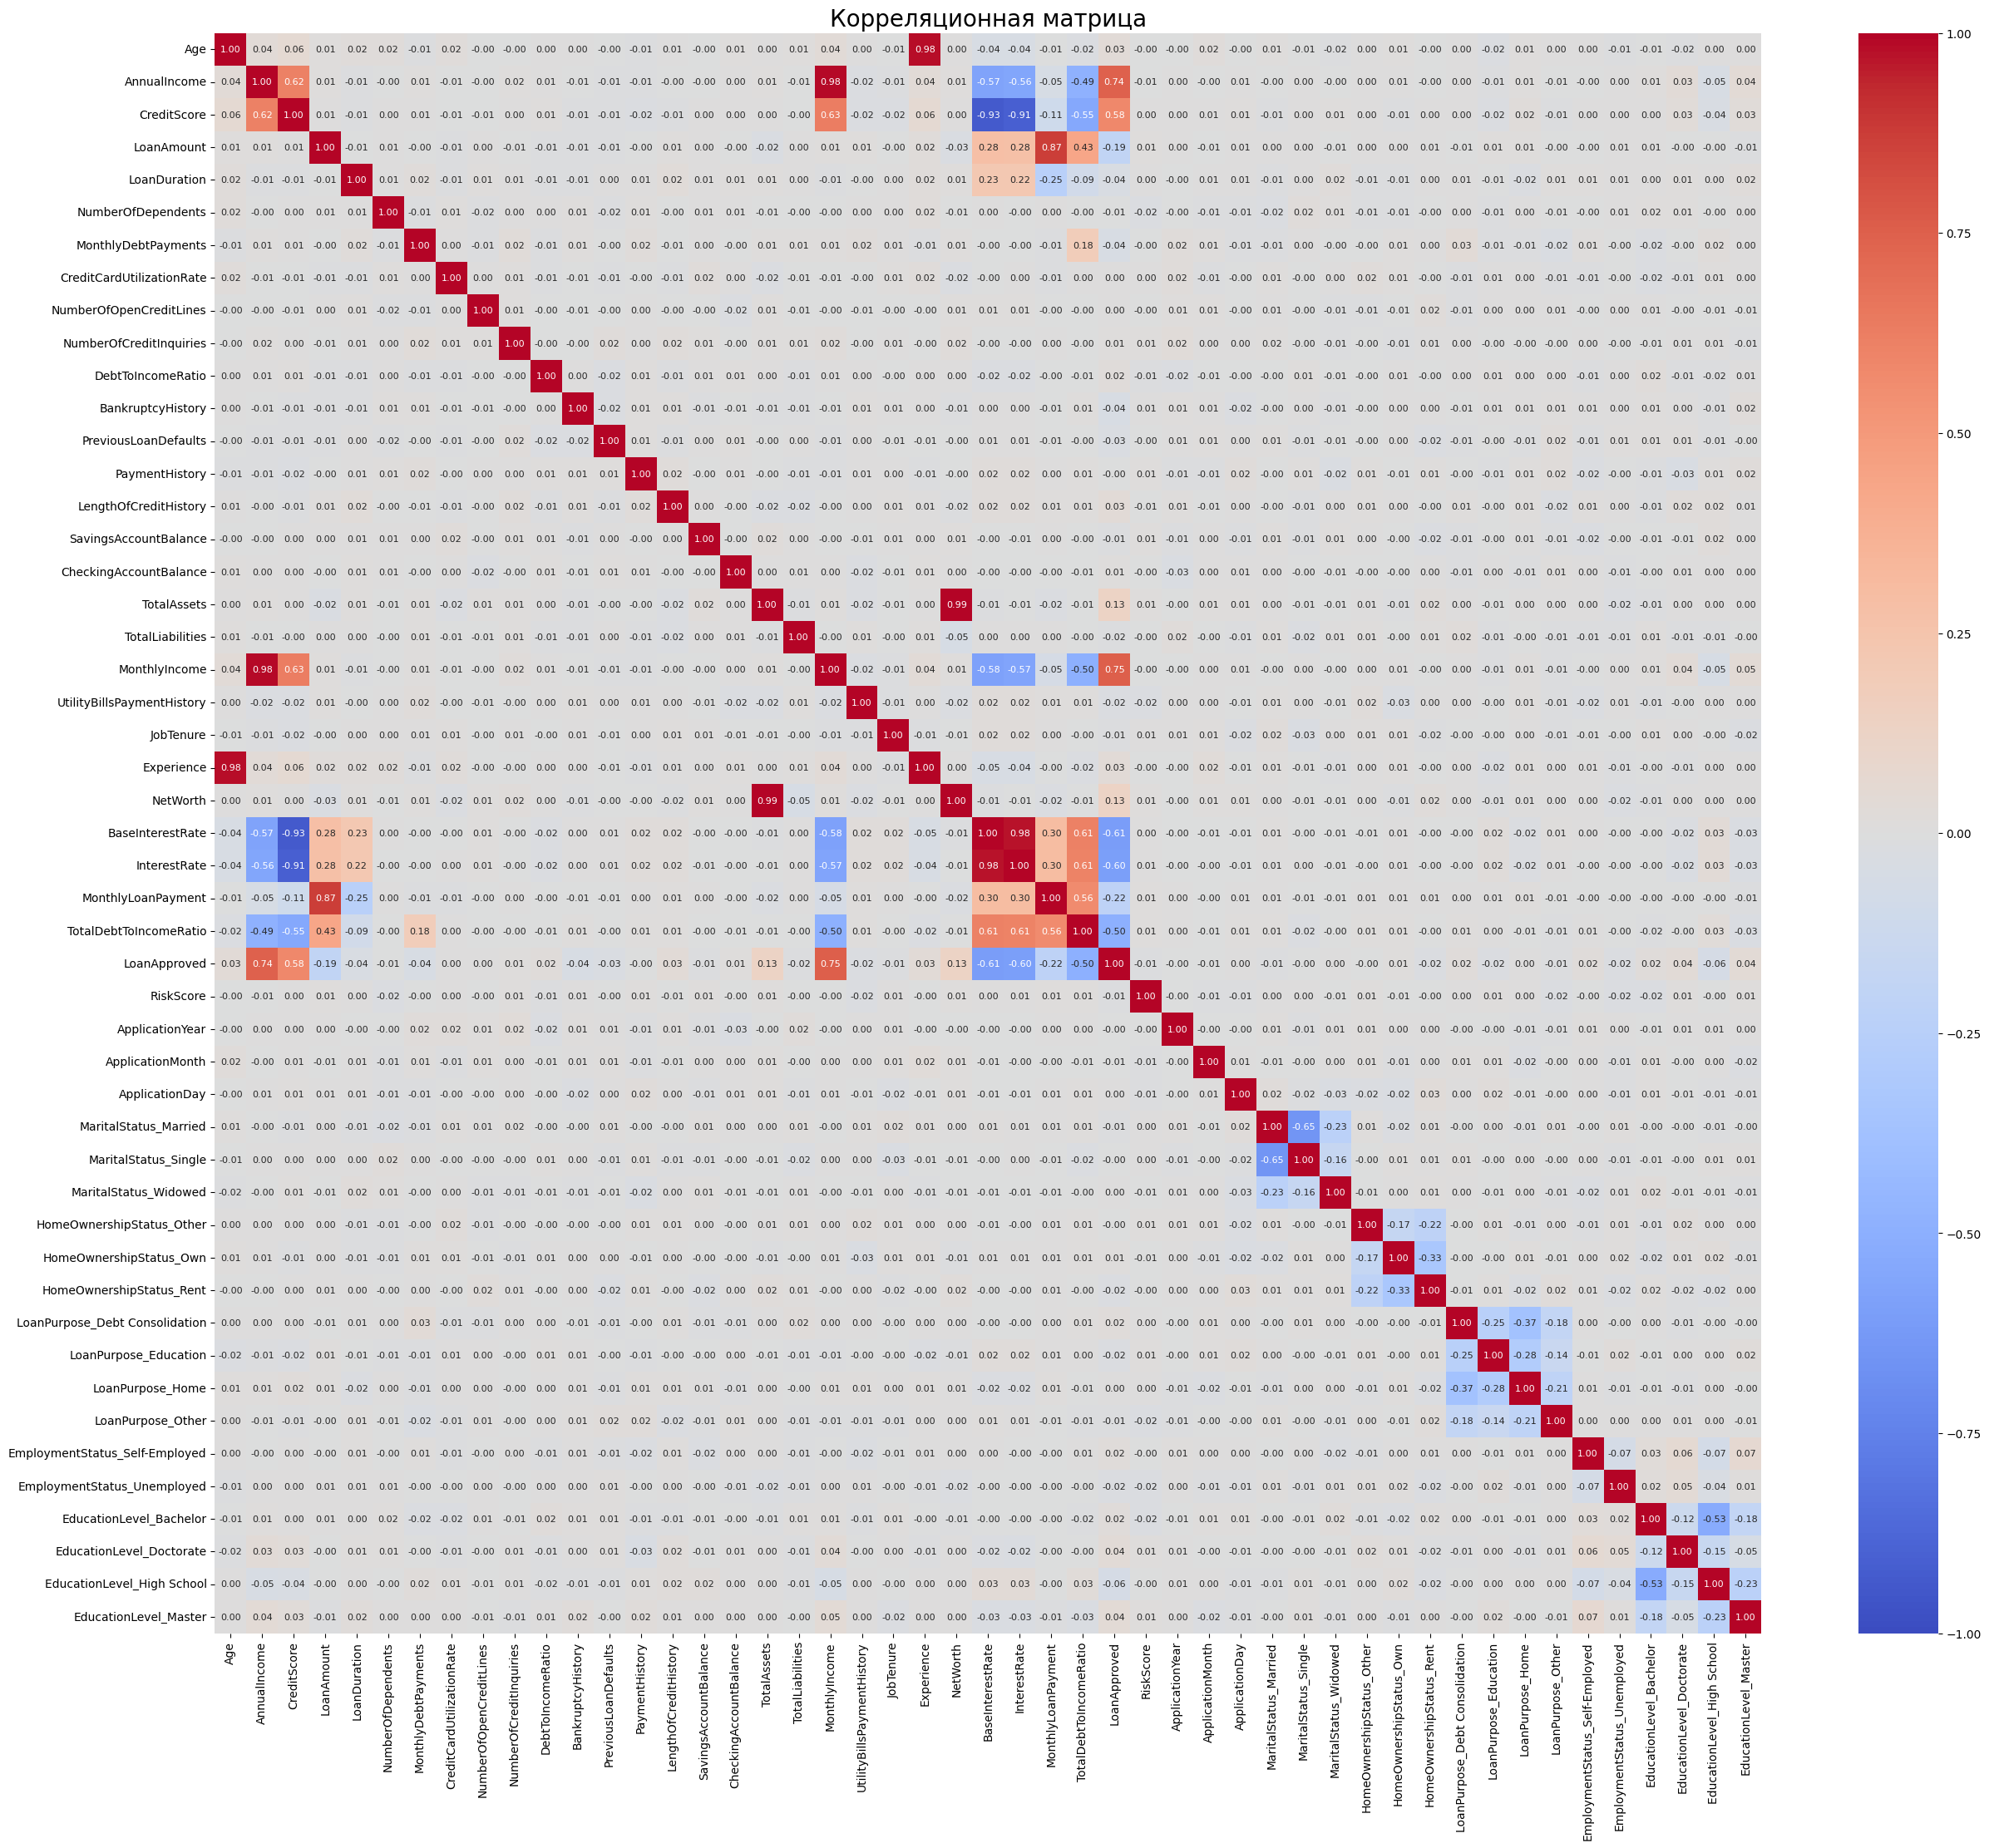

In [231]:
corr_mtrx = train_data.corr()

plt.figure(figsize=(30, 25))
sns.heatmap(corr_mtrx, annot=True, fmt=".2f", annot_kws={"size": 8}, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Корреляционная матрица", fontsize=20)
plt.show()


Обычно удаляют признаки, которые сильно коррелируют друг с другом. Часто используют порог корреляции, например, 0.8 или -0.8. Это позволяет избавиться от мультиколлинеарности.  
Если два признака коррелируют сильно, можно удалить один из них, чтобы избежать избыточной информации.

In [232]:
# Устанавливаем порог корреляции
correlation_threshold = 0.8

high_corr = corr_mtrx[(corr_mtrx >= correlation_threshold) & (corr_mtrx != 1.)].stack()
print(high_corr)

corr_mtrx = train_data.corr().abs()
upper_tri = corr_mtrx.where(np.triu(np.ones(corr_mtrx.shape), k=1).astype(bool))
# Выбираем признаки, которые коррелируют выше порога
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > correlation_threshold) and column != 'NetWorth']
# не трогаю netwoth, так как по моему мнению это важный столбец, а моим методом, этот столбец входит
# в удаляемые

train_data = train_data.drop(columns=to_drop)
test_data = test_data.drop(columns=to_drop)

print(f"Удалены следующие признаки: {to_drop}")

Age                 Experience            0.982835
AnnualIncome        MonthlyIncome         0.984377
LoanAmount          MonthlyLoanPayment    0.868396
TotalAssets         NetWorth              0.993873
MonthlyIncome       AnnualIncome          0.984377
Experience          Age                   0.982835
NetWorth            TotalAssets           0.993873
BaseInterestRate    InterestRate          0.975232
InterestRate        BaseInterestRate      0.975232
MonthlyLoanPayment  LoanAmount            0.868396
dtype: float64
Удалены следующие признаки: ['MonthlyIncome', 'Experience', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment']


#  Нормализация

In [233]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Age

По графику видно, что распределение нормальное (ну почти), поэтому применим z-score

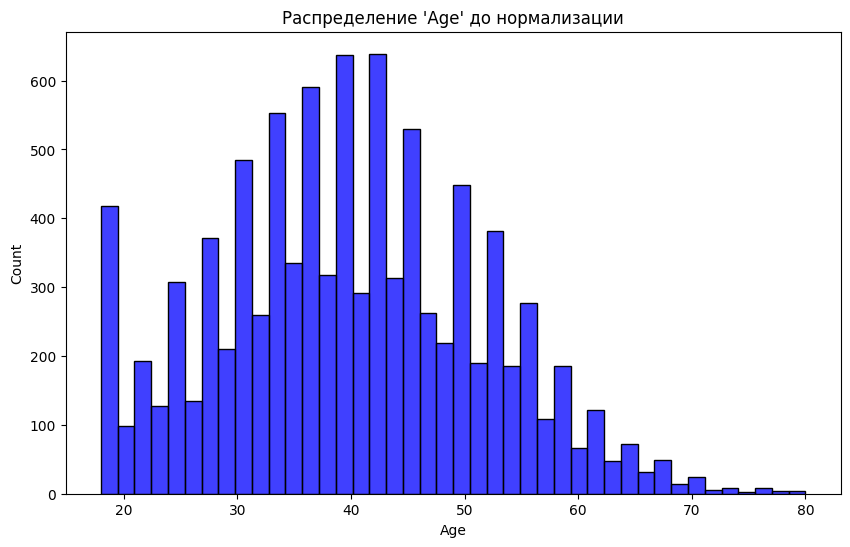

In [234]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['Age'],  color='blue')
plt.title("Распределение 'Age' до нормализации")
plt.show()

# Z-score нормализация
scaler_z = StandardScaler()
train_data['Age'] = scaler_z.fit_transform(train_data[['Age']])
test_data['Age'] = scaler_z.fit_transform(test_data[['Age']])


## ApplicationYear
Распределение равномерное - использую min-max

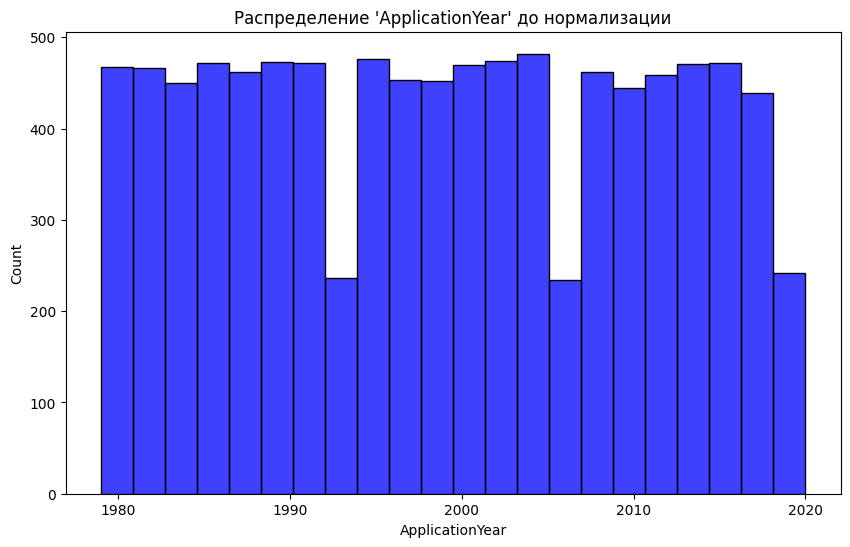

In [235]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['ApplicationYear'],  color='blue')
plt.title("Распределение 'ApplicationYear' до нормализации")
plt.show()

scaler_minmax = MinMaxScaler()
train_data['ApplicationYear'] = scaler_minmax.fit_transform(train_data[['ApplicationYear']])
test_data['ApplicationYear'] = scaler_minmax.fit_transform(test_data[['ApplicationYear']])


## ApplicationMonth
Распределение равномерное - использую min-max

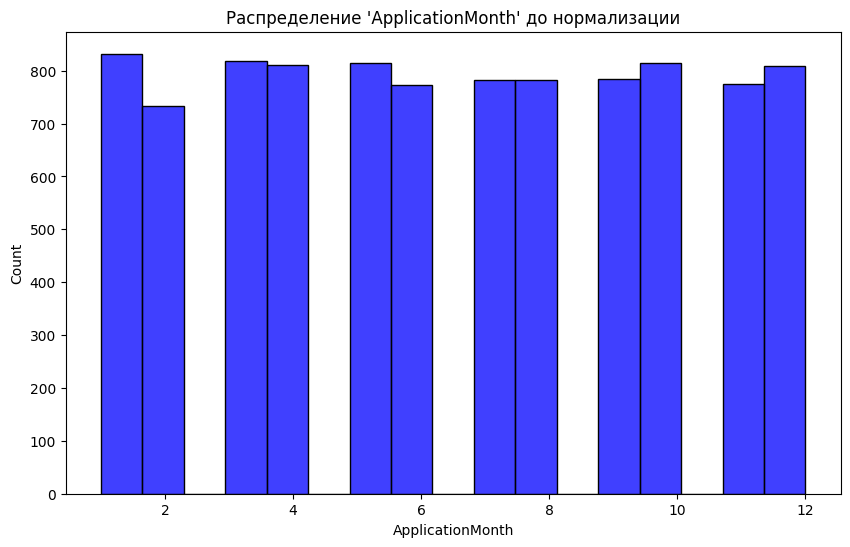

In [236]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['ApplicationMonth'],  color='blue')
plt.title("Распределение 'ApplicationMonth' до нормализации")
plt.show()

scaler_minmax = MinMaxScaler()
train_data['ApplicationMonth'] = scaler_minmax.fit_transform(train_data[['ApplicationMonth']])
test_data['ApplicationMonth'] = scaler_minmax.fit_transform(test_data[['ApplicationMonth']])

## ApplicationDay
Распределение равномерное - использую min-max

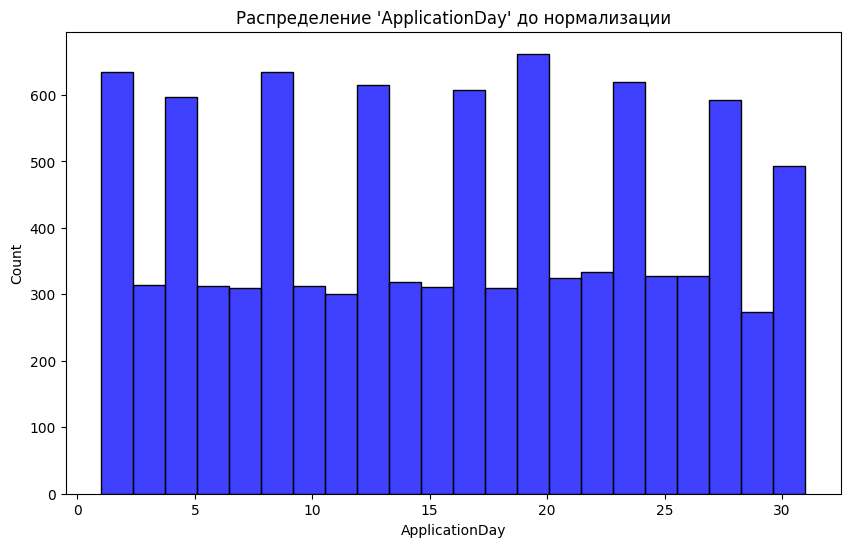

In [237]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['ApplicationDay'],  color='blue')
plt.title("Распределение 'ApplicationDay' до нормализации")
plt.show()

scaler_minmax = MinMaxScaler()
train_data['ApplicationDay'] = scaler_minmax.fit_transform(train_data[['ApplicationDay']])
test_data['ApplicationDay'] = scaler_minmax.fit_transform(test_data[['ApplicationDay']])


# AnnualIncome
Так как, как наш график сильно похож на экспоненциальный, прологарифмируем его и заметим, что данные почти равномерно распределены. И поэтому применим minmax

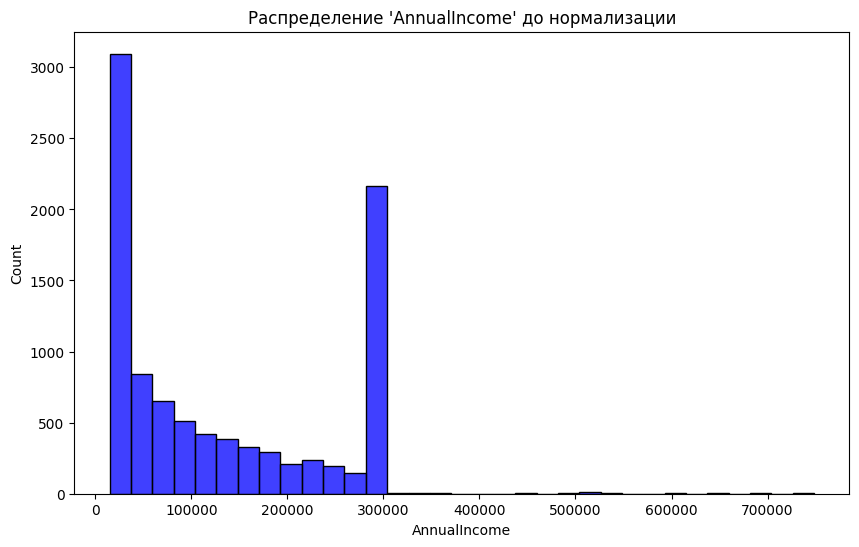

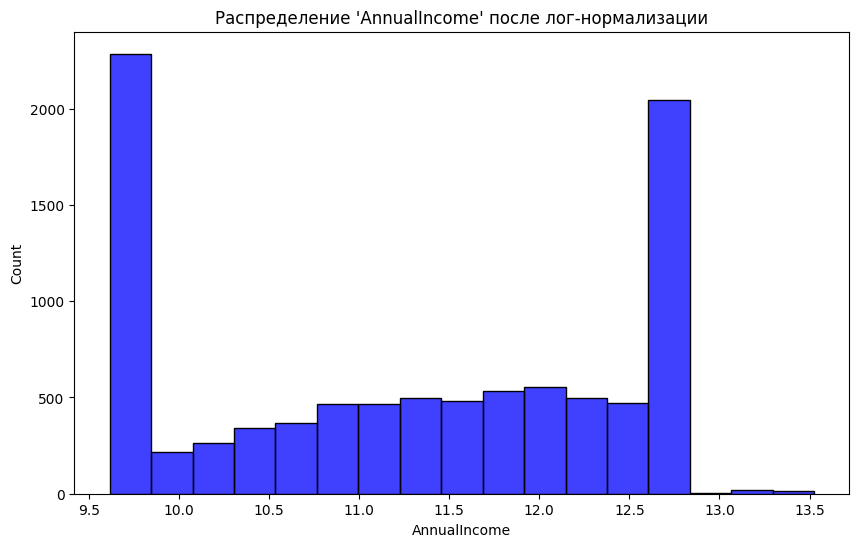

In [238]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['AnnualIncome'],  color='blue')
plt.title("Распределение 'AnnualIncome' до нормализации")
plt.show()

train_data['AnnualIncome'] = np.log1p(train_data['AnnualIncome'])
test_data['AnnualIncome'] = np.log1p(test_data['AnnualIncome'])

plt.figure(figsize=(10, 6))
sns.histplot(train_data['AnnualIncome'],  color='blue')
plt.title("Распределение 'AnnualIncome' после лог-нормализации")
plt.show()

scaler_minmax = MinMaxScaler()
train_data['AnnualIncome'] = scaler_minmax.fit_transform(train_data[['AnnualIncome']])
test_data['AnnualIncome'] = scaler_minmax.fit_transform(test_data[['AnnualIncome']])


# CreditScore

равномерное распределение - minmax

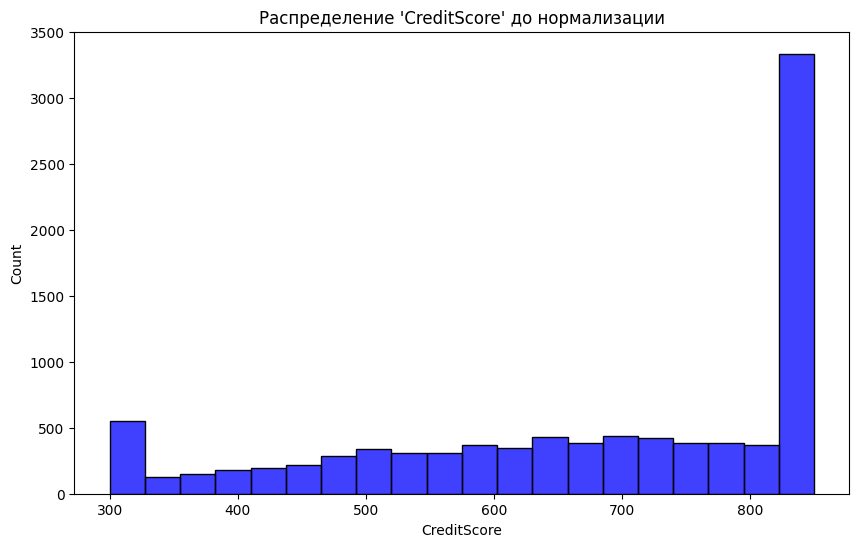

In [239]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['CreditScore'],  color='blue')
plt.title("Распределение 'CreditScore' до нормализации")
plt.show()

scaler_minmax = MinMaxScaler()
train_data['CreditScore'] = scaler_minmax.fit_transform(train_data[['CreditScore']])
test_data['CreditScore'] = scaler_minmax.fit_transform(test_data[['CreditScore']])

# LoanAmount

Экспонента - log1p + z-score, так как после лог. получили нормальное распределение

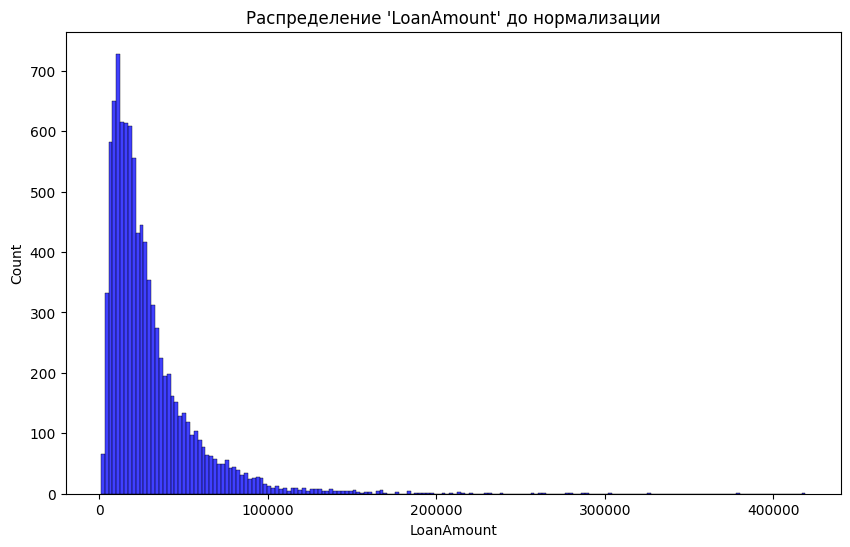

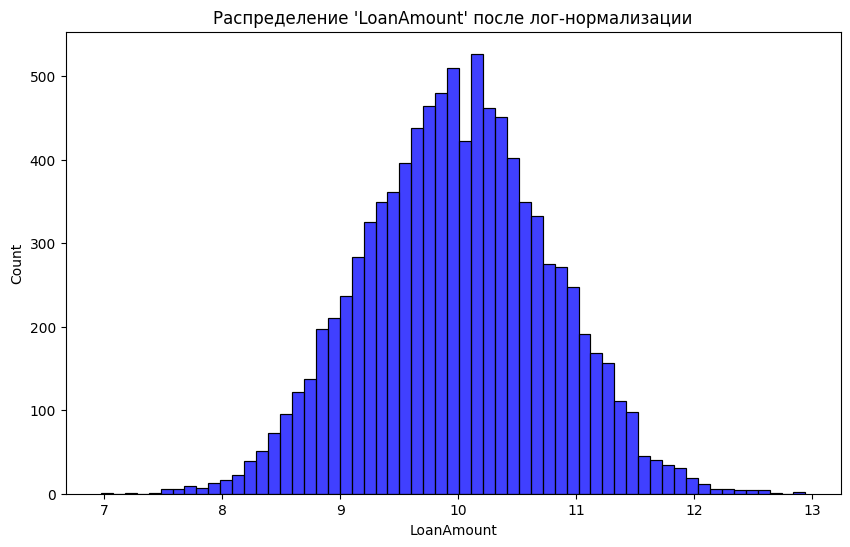

In [240]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['LoanAmount'],  color='blue')
plt.title("Распределение 'LoanAmount' до нормализации")
plt.show()

train_data['LoanAmount'] = np.log1p(train_data['LoanAmount'])
test_data['LoanAmount'] = np.log1p(test_data['LoanAmount'])

plt.figure(figsize=(10, 6))
sns.histplot(train_data['LoanAmount'],  color='blue')
plt.title("Распределение 'LoanAmount' после лог-нормализации")
plt.show()

scaler_z = StandardScaler()
train_data['LoanAmount'] = scaler_z.fit_transform(train_data[['LoanAmount']])
test_data['LoanAmount'] = scaler_z.fit_transform(test_data[['LoanAmount']])

# LoanDuration

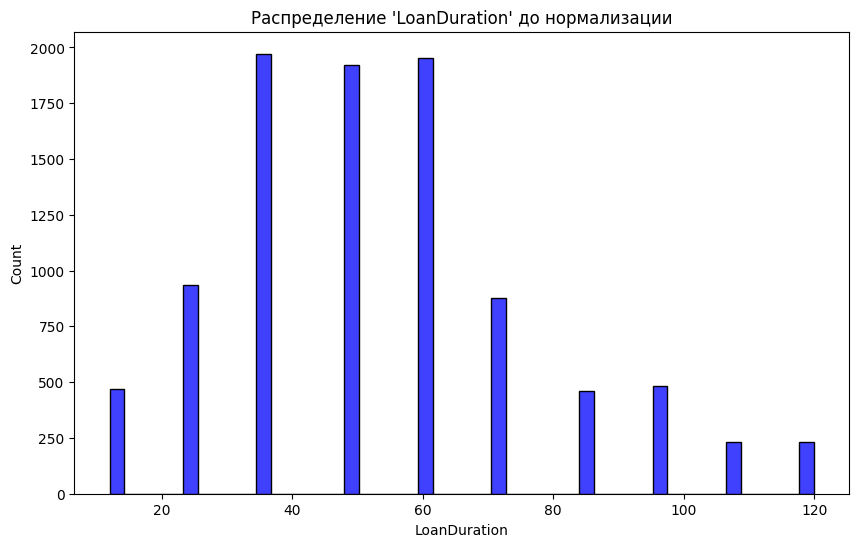

In [241]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['LoanDuration'], color='blue')
plt.title("Распределение 'LoanDuration' до нормализации")
plt.show()

scaler_z = StandardScaler()
train_data['LoanDuration'] = scaler_z.fit_transform(train_data[['LoanDuration']])
test_data['LoanDuration'] = scaler_z.fit_transform(test_data[['LoanDuration']])


#  MaritalStatus, HomeOwnershipStatus, LoanPurpose, EmploymentStatus, EducationLevel, BankruptcyHistory, PreviousLoanDefaults 
В нормализации не нуждаются, так как являются категориальными


# NumberOfDependents

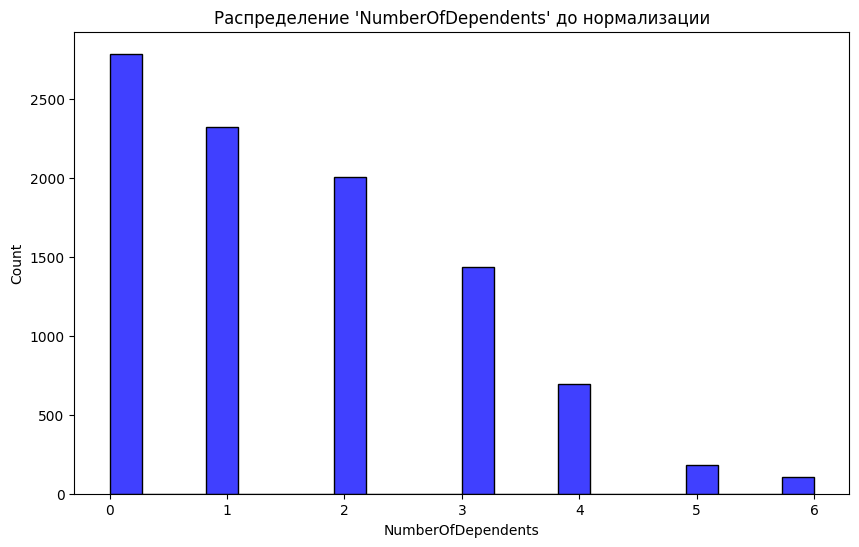

In [242]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['NumberOfDependents'], color='blue')
plt.title("Распределение 'NumberOfDependents' до нормализации")
plt.show()

# прологарифмировал, так как неясно было что делать с таким графиком
train_data['NumberOfDependents'] = np.log1p(train_data['NumberOfDependents'])
test_data['NumberOfDependents'] = np.log1p(test_data['NumberOfDependents'])

# так как minmax явно здесь что-то сломает, использую z-score

scaler_z = StandardScaler()
train_data['NumberOfDependents'] = scaler_z.fit_transform(train_data[['NumberOfDependents']])
test_data['NumberOfDependents'] = scaler_z.fit_transform(test_data[['NumberOfDependents']])

# MonthlyDebtPayments

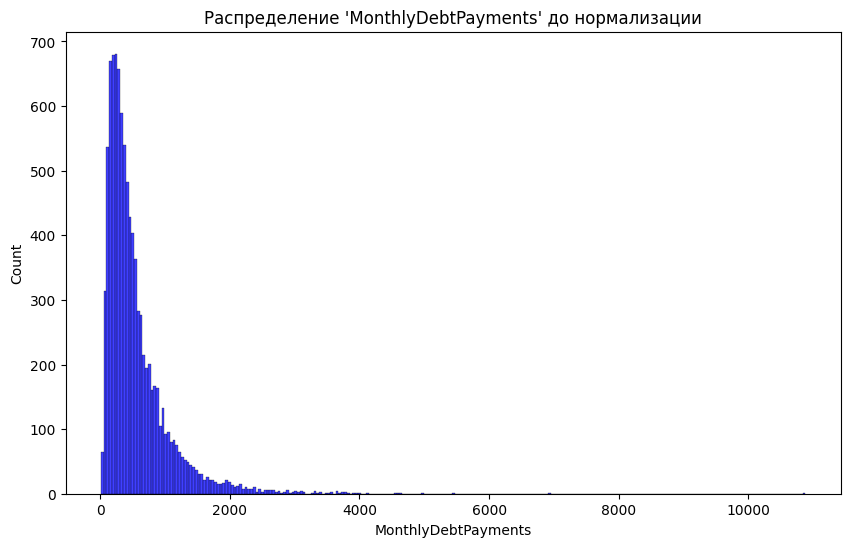

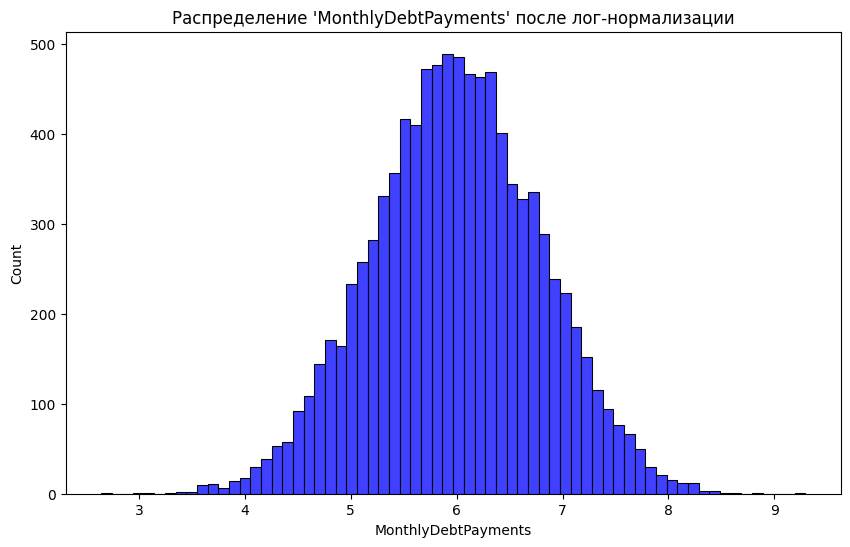

In [243]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['MonthlyDebtPayments'], color='blue')
plt.title("Распределение 'MonthlyDebtPayments' до нормализации")
plt.show()

# явно видно экспоненциальную функцию, логарифмируем
train_data['MonthlyDebtPayments'] = np.log1p(train_data['MonthlyDebtPayments'])
test_data['MonthlyDebtPayments'] = np.log1p(test_data['MonthlyDebtPayments'])

plt.figure(figsize=(10, 6))
sns.histplot(train_data['MonthlyDebtPayments'], color='blue')
plt.title("Распределение 'MonthlyDebtPayments' после лог-нормализации")
plt.show()

scaler_z = StandardScaler()
train_data['MonthlyDebtPayments'] = scaler_z.fit_transform(train_data[['MonthlyDebtPayments']])
test_data['MonthlyDebtPayments'] = scaler_z.fit_transform(test_data[['MonthlyDebtPayments']])

# CreditCardUtilizationRate

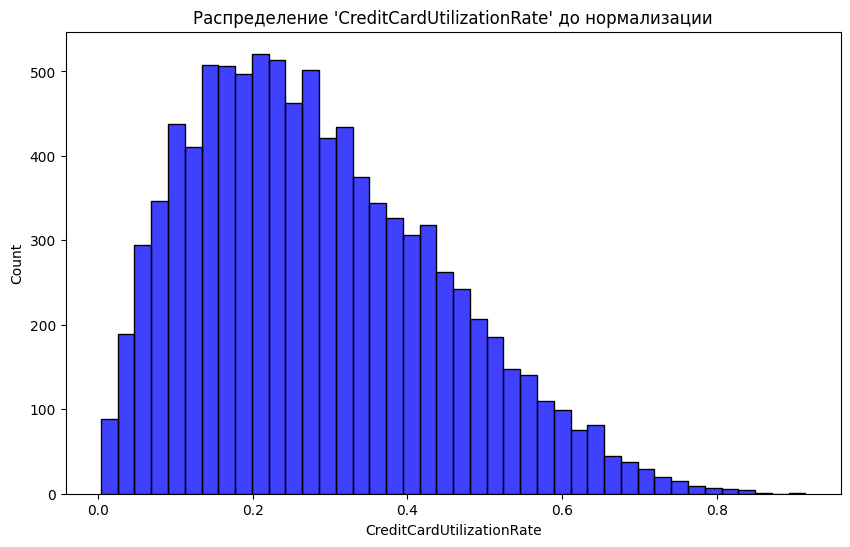

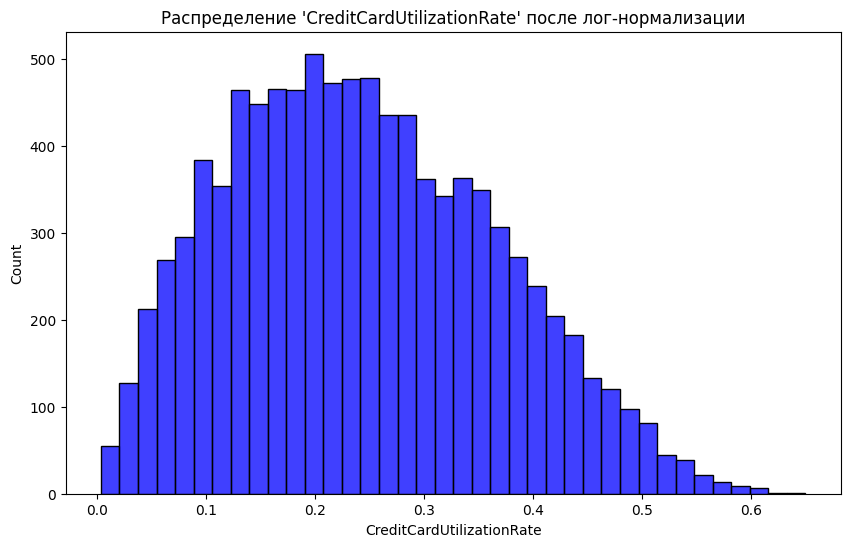

In [244]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['CreditCardUtilizationRate'], color='blue')
plt.title("Распределение 'CreditCardUtilizationRate' до нормализации")
plt.show()

train_data['CreditCardUtilizationRate'] = np.log1p(train_data['CreditCardUtilizationRate'])
test_data['CreditCardUtilizationRate'] = np.log1p(test_data['CreditCardUtilizationRate'])

plt.figure(figsize=(10, 6))
sns.histplot(train_data['CreditCardUtilizationRate'], color='blue')
plt.title("Распределение 'CreditCardUtilizationRate' после лог-нормализации")
plt.show()

scaler_z = StandardScaler()
train_data['CreditCardUtilizationRate'] = scaler_z.fit_transform(train_data[['CreditCardUtilizationRate']])
test_data['CreditCardUtilizationRate'] = scaler_z.fit_transform(test_data[['CreditCardUtilizationRate']])


# NumberOfOpenCreditLines

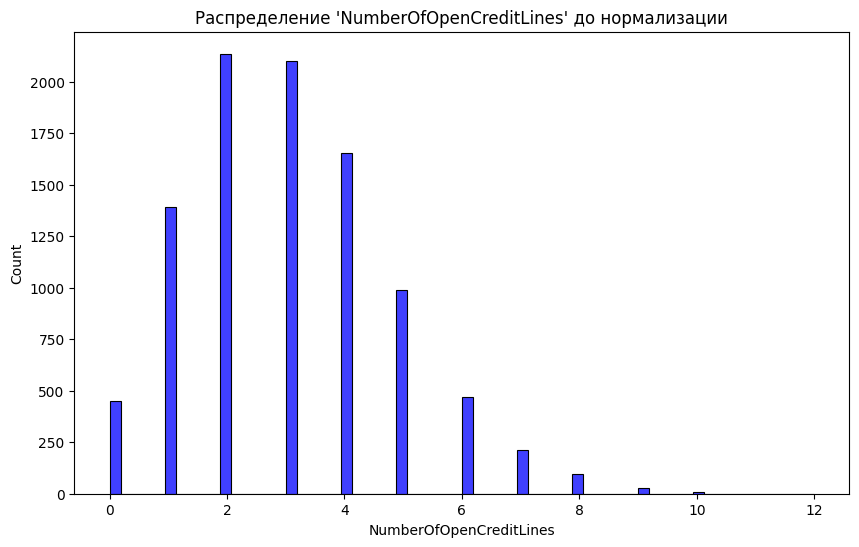

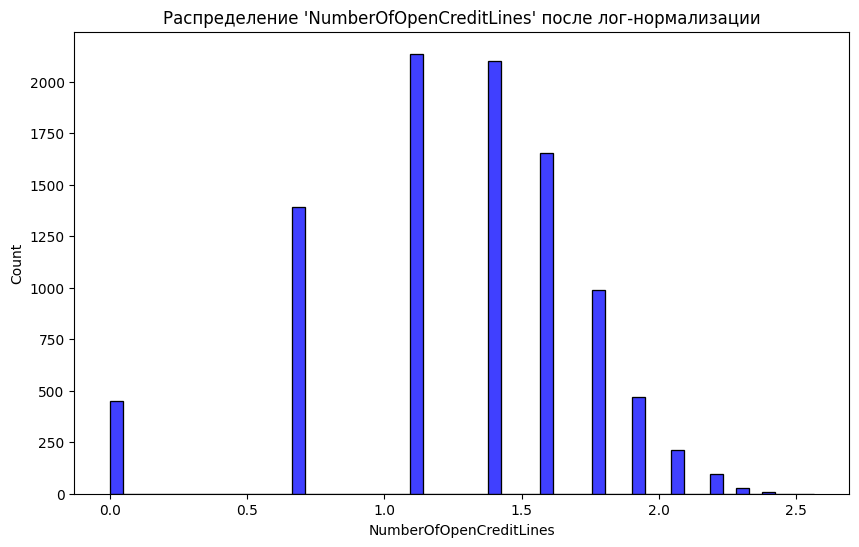

In [245]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['NumberOfOpenCreditLines'], color='blue')
plt.title("Распределение 'NumberOfOpenCreditLines' до нормализации")
plt.show()

train_data['NumberOfOpenCreditLines'] = np.log1p(train_data['NumberOfOpenCreditLines'])
test_data['NumberOfOpenCreditLines'] = np.log1p(test_data['NumberOfOpenCreditLines'])

plt.figure(figsize=(10, 6))
sns.histplot(train_data['NumberOfOpenCreditLines'], color='blue')
plt.title("Распределение 'NumberOfOpenCreditLines' после лог-нормализации")
plt.show()

scaler_z = StandardScaler()
train_data['NumberOfOpenCreditLines'] = scaler_z.fit_transform(train_data[['NumberOfOpenCreditLines']])
test_data['NumberOfOpenCreditLines'] = scaler_z.fit_transform(test_data[['NumberOfOpenCreditLines']])


# NumberOfCreditInquiries

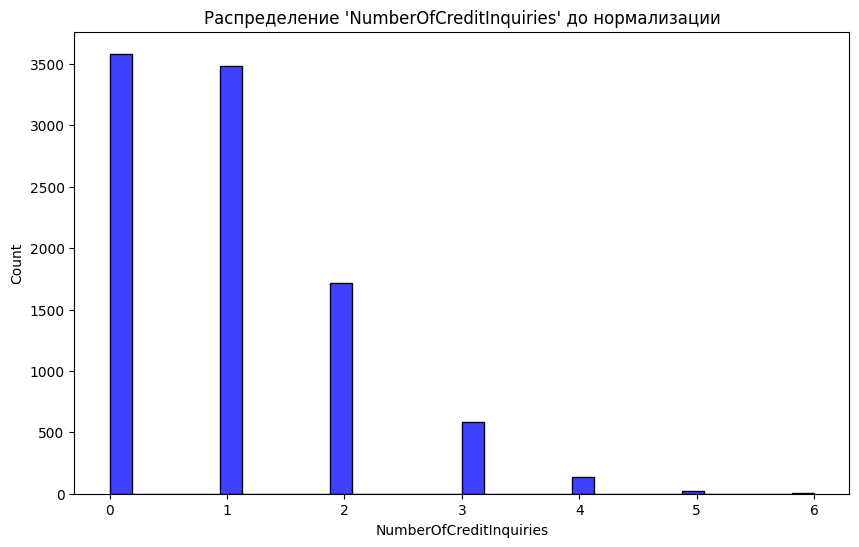

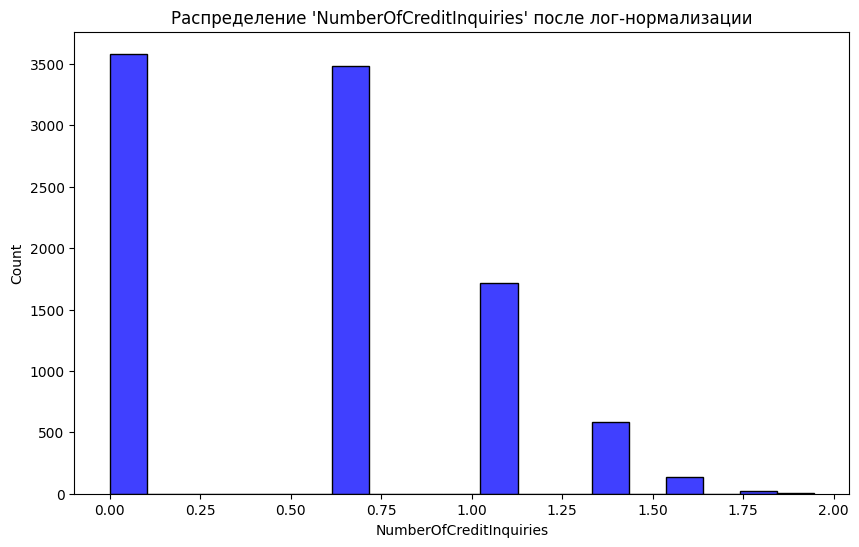

In [246]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['NumberOfCreditInquiries'], color='blue')
plt.title("Распределение 'NumberOfCreditInquiries' до нормализации")
plt.show()

train_data['NumberOfCreditInquiries'] = np.log1p(train_data['NumberOfCreditInquiries'])
test_data['NumberOfCreditInquiries'] = np.log1p(test_data['NumberOfCreditInquiries'])

plt.figure(figsize=(10, 6))
sns.histplot(train_data['NumberOfCreditInquiries'], color='blue')
plt.title("Распределение 'NumberOfCreditInquiries' после лог-нормализации")
plt.show()

scaler_z = StandardScaler()
train_data['NumberOfCreditInquiries'] = scaler_z.fit_transform(train_data[['NumberOfCreditInquiries']])
test_data['NumberOfCreditInquiries'] = scaler_z.fit_transform(test_data[['NumberOfCreditInquiries']])


# DebtToIncomeRatio

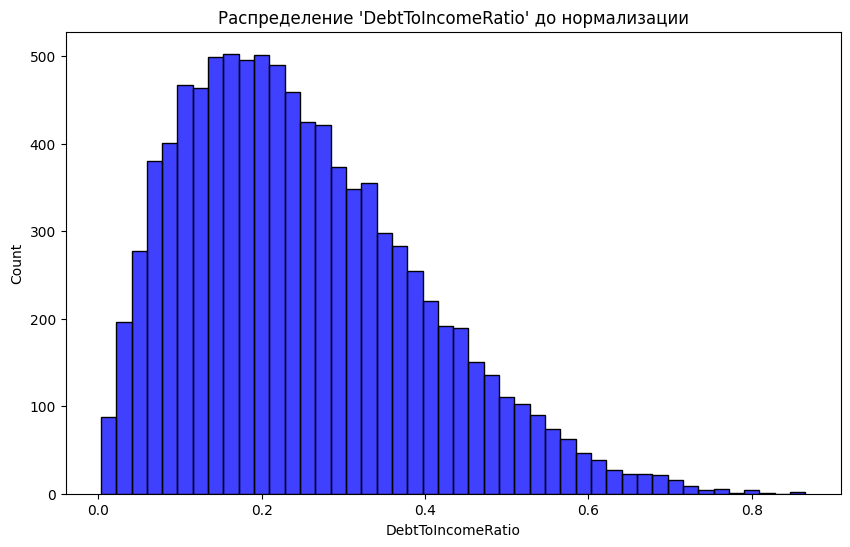

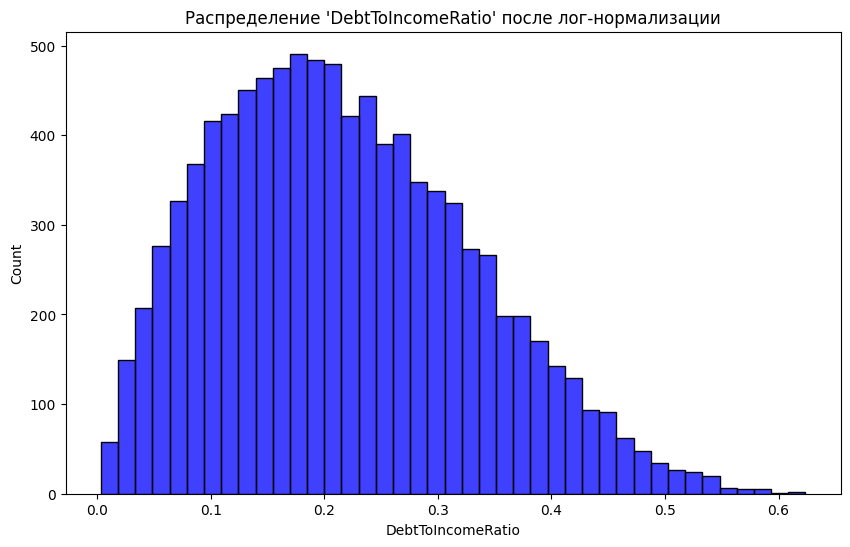

In [247]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['DebtToIncomeRatio'], color='blue')
plt.title("Распределение 'DebtToIncomeRatio' до нормализации")
plt.show()

train_data['DebtToIncomeRatio'] = np.log1p(train_data['DebtToIncomeRatio'])
test_data['DebtToIncomeRatio'] = np.log1p(test_data['DebtToIncomeRatio'])

plt.figure(figsize=(10, 6))
sns.histplot(train_data['DebtToIncomeRatio'], color='blue')
plt.title("Распределение 'DebtToIncomeRatio' после лог-нормализации")
plt.show()

scaler_z = StandardScaler()
train_data['DebtToIncomeRatio'] = scaler_z.fit_transform(train_data[['DebtToIncomeRatio']])
test_data['DebtToIncomeRatio'] = scaler_z.fit_transform(test_data[['DebtToIncomeRatio']])

# PaymentHistory

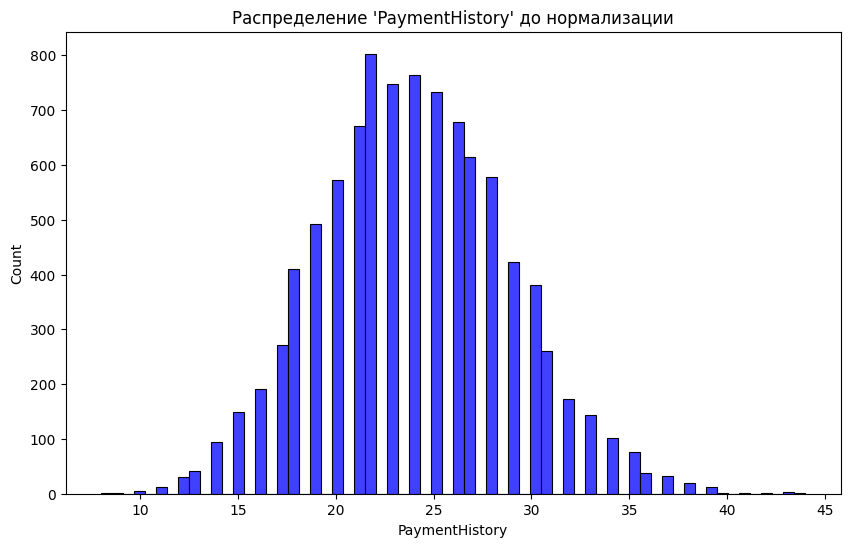

In [248]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['PaymentHistory'], color='blue')
plt.title("Распределение 'PaymentHistory' до нормализации")
plt.show()

scaler_z = StandardScaler()
train_data['PaymentHistory'] = scaler_z.fit_transform(train_data[['PaymentHistory']])
test_data['PaymentHistory'] = scaler_z.fit_transform(test_data[['PaymentHistory']])

# LengthOfCreditHistory

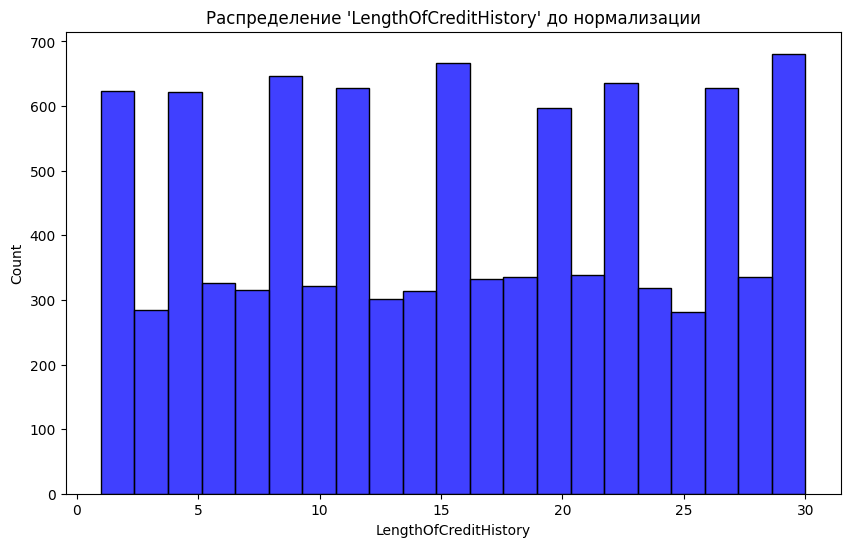

In [249]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['LengthOfCreditHistory'], color='blue')
plt.title("Распределение 'LengthOfCreditHistory' до нормализации")
plt.show()

scaler_minmax = MinMaxScaler()
train_data['LengthOfCreditHistory'] = scaler_minmax.fit_transform(train_data[['LengthOfCreditHistory']])
test_data['LengthOfCreditHistory'] = scaler_minmax.fit_transform(test_data[['LengthOfCreditHistory']])

# SavingsAccountBalance

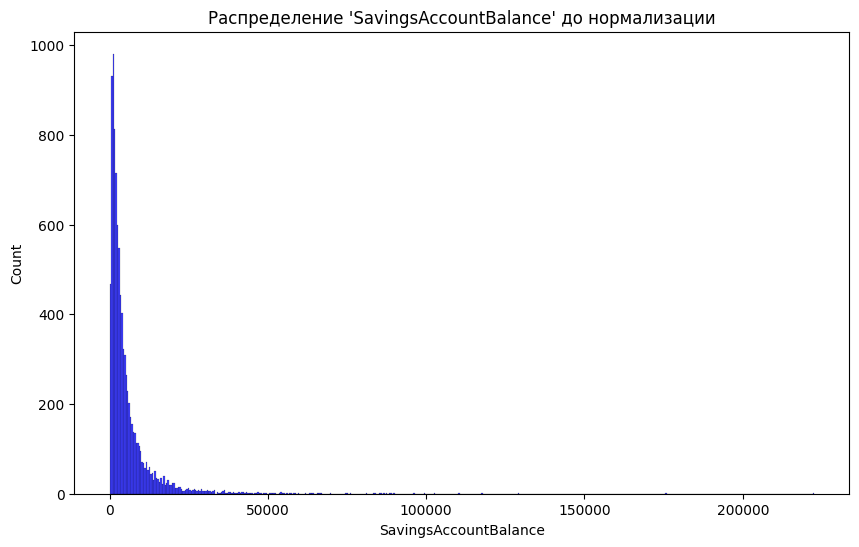

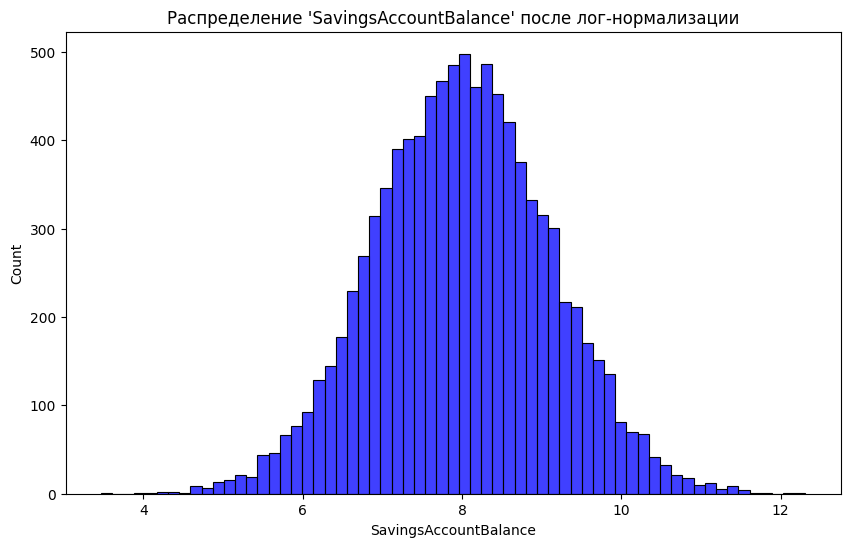

In [250]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['SavingsAccountBalance'], color='blue')
plt.title("Распределение 'SavingsAccountBalance' до нормализации")
plt.show()

train_data['SavingsAccountBalance'] = np.log1p(train_data['SavingsAccountBalance'])
test_data['SavingsAccountBalance'] = np.log1p(test_data['SavingsAccountBalance'])

plt.figure(figsize=(10, 6))
sns.histplot(train_data['SavingsAccountBalance'], color='blue')
plt.title("Распределение 'SavingsAccountBalance' после лог-нормализации")
plt.show()

scaler_z = StandardScaler()
train_data['SavingsAccountBalance'] = scaler_z.fit_transform(train_data[['SavingsAccountBalance']])
test_data['SavingsAccountBalance'] = scaler_z.fit_transform(test_data[['SavingsAccountBalance']])

# CheckingAccountBalance

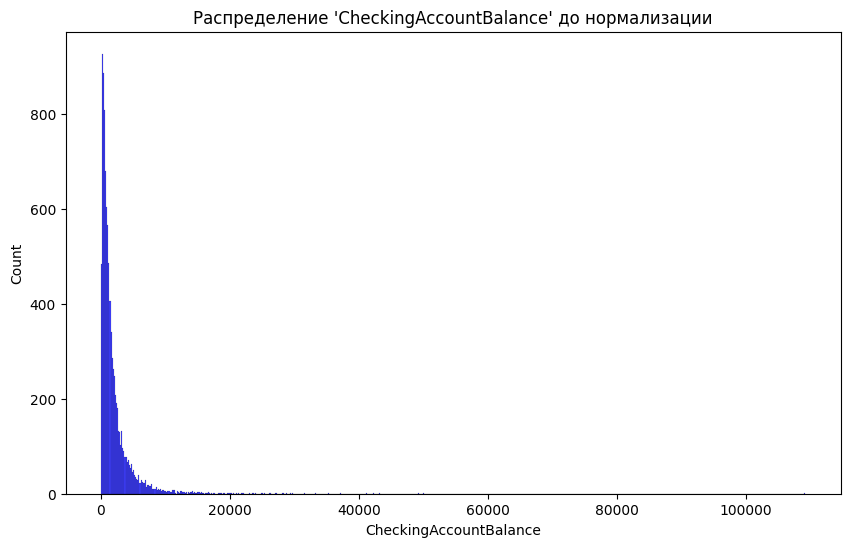

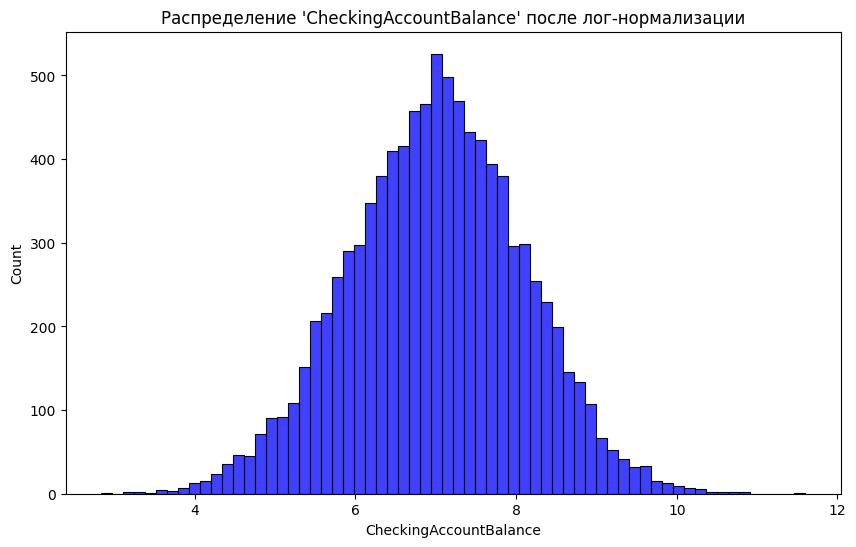

In [251]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['CheckingAccountBalance'], color='blue')
plt.title("Распределение 'CheckingAccountBalance' до нормализации")
plt.show()

train_data['CheckingAccountBalance'] = np.log1p(train_data['CheckingAccountBalance'])
test_data['CheckingAccountBalance'] = np.log1p(test_data['CheckingAccountBalance'])

plt.figure(figsize=(10, 6))
sns.histplot(train_data['CheckingAccountBalance'], color='blue')
plt.title("Распределение 'CheckingAccountBalance' после лог-нормализации")
plt.show()

scaler_z = StandardScaler()
train_data['CheckingAccountBalance'] = scaler_z.fit_transform(train_data[['CheckingAccountBalance']])
test_data['CheckingAccountBalance'] = scaler_z.fit_transform(test_data[['CheckingAccountBalance']])

# TotalAssets

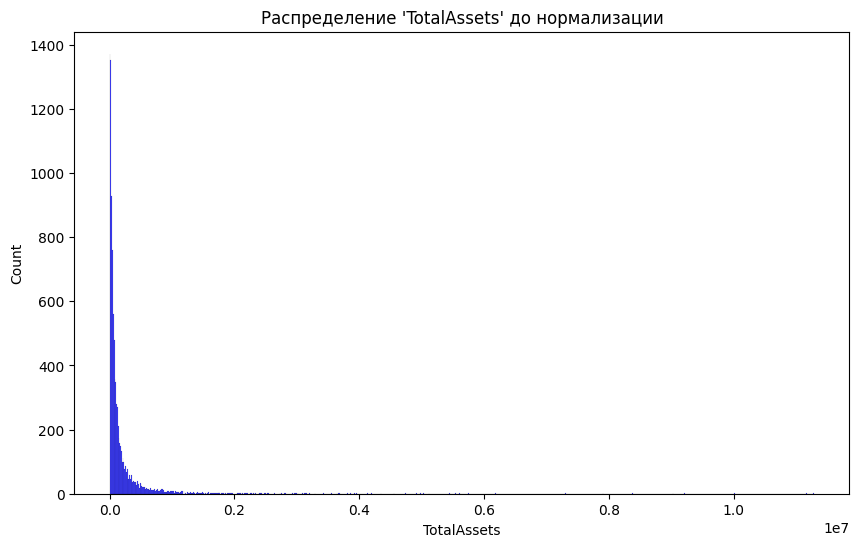

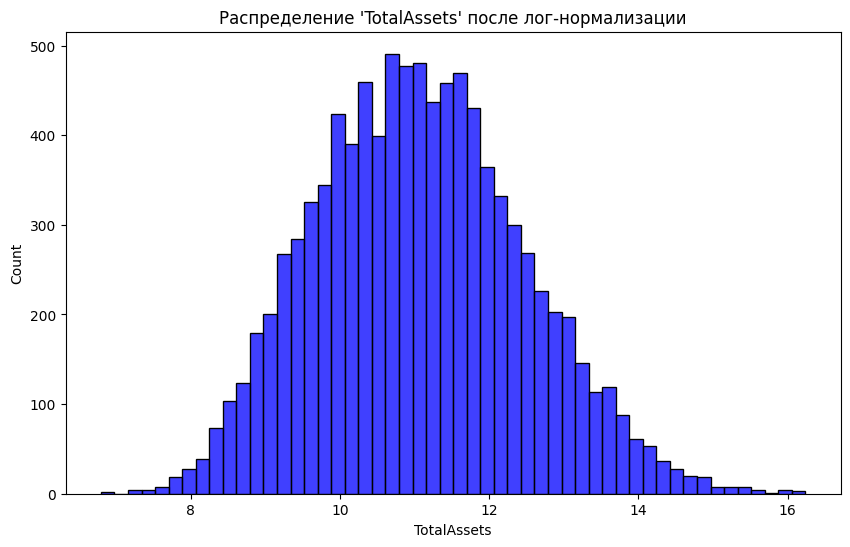

In [252]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['TotalAssets'], color='blue')
plt.title("Распределение 'TotalAssets' до нормализации")
plt.show()

train_data['TotalAssets'] = np.log1p(train_data['TotalAssets'])
test_data['TotalAssets'] = np.log1p(test_data['TotalAssets'])

plt.figure(figsize=(10, 6))
sns.histplot(train_data['TotalAssets'], color='blue')
plt.title("Распределение 'TotalAssets' после лог-нормализации")
plt.show()

scaler_z = StandardScaler()
train_data['TotalAssets'] = scaler_z.fit_transform(train_data[['TotalAssets']])
test_data['TotalAssets'] = scaler_z.fit_transform(test_data[['TotalAssets']])

# TotalLiabilities

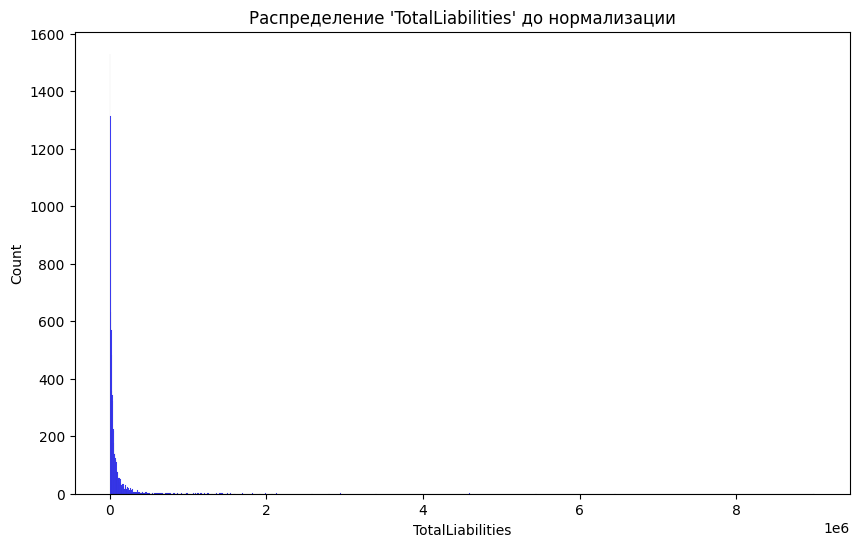

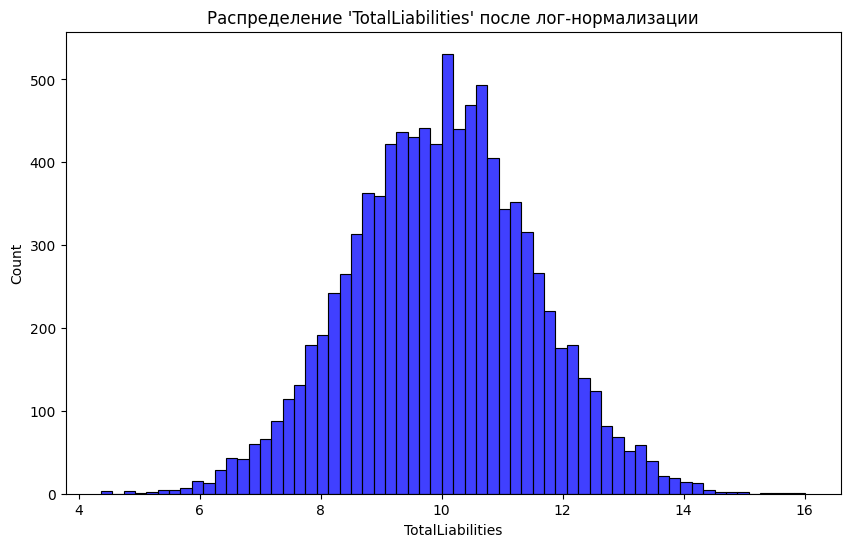

In [253]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['TotalLiabilities'], color='blue')
plt.title("Распределение 'TotalLiabilities' до нормализации")
plt.show()

train_data['TotalLiabilities'] = np.log1p(train_data['TotalLiabilities'])
test_data['TotalLiabilities'] = np.log1p(test_data['TotalLiabilities'])

plt.figure(figsize=(10, 6))
sns.histplot(train_data['TotalLiabilities'], color='blue')
plt.title("Распределение 'TotalLiabilities' после лог-нормализации")
plt.show()

scaler_z = StandardScaler()
train_data['TotalLiabilities'] = scaler_z.fit_transform(train_data[['TotalLiabilities']])
test_data['TotalLiabilities'] = scaler_z.fit_transform(test_data[['TotalLiabilities']])

# JobTenure

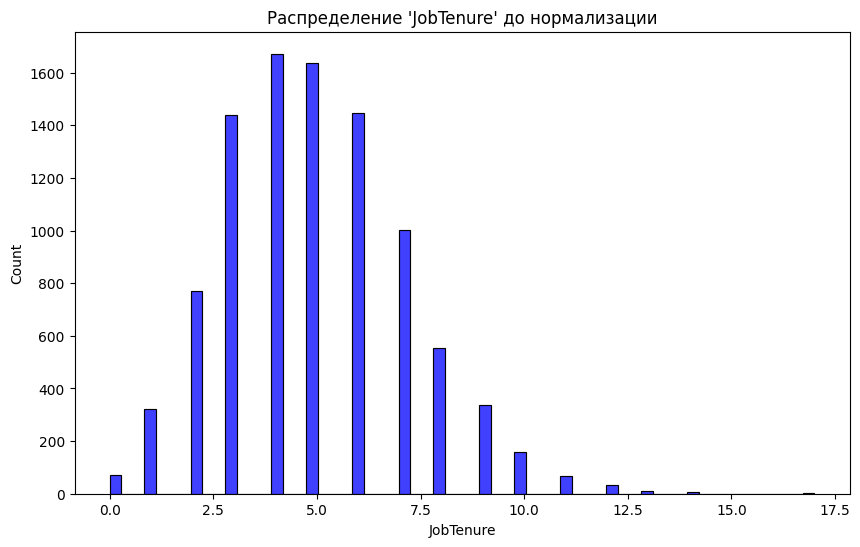

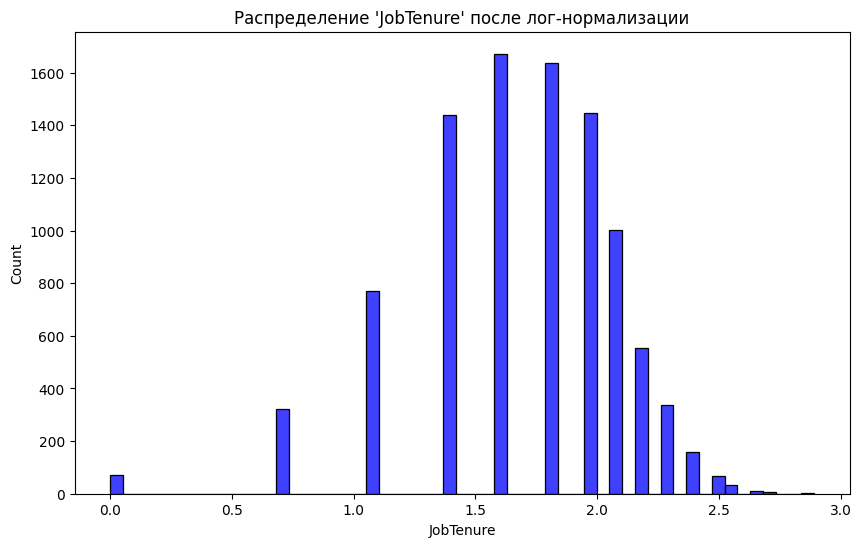

In [254]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['JobTenure'], color='blue')
plt.title("Распределение 'JobTenure' до нормализации")
plt.show()

train_data['JobTenure'] = np.log1p(train_data['JobTenure'])
test_data['JobTenure'] = np.log1p(test_data['JobTenure'])

plt.figure(figsize=(10, 6))
sns.histplot(train_data['JobTenure'], color='blue')
plt.title("Распределение 'JobTenure' после лог-нормализации")
plt.show()

scaler_z = StandardScaler()
train_data['JobTenure'] = scaler_z.fit_transform(train_data[['JobTenure']])
test_data['JobTenure'] = scaler_z.fit_transform(test_data[['JobTenure']])

# NetWorth

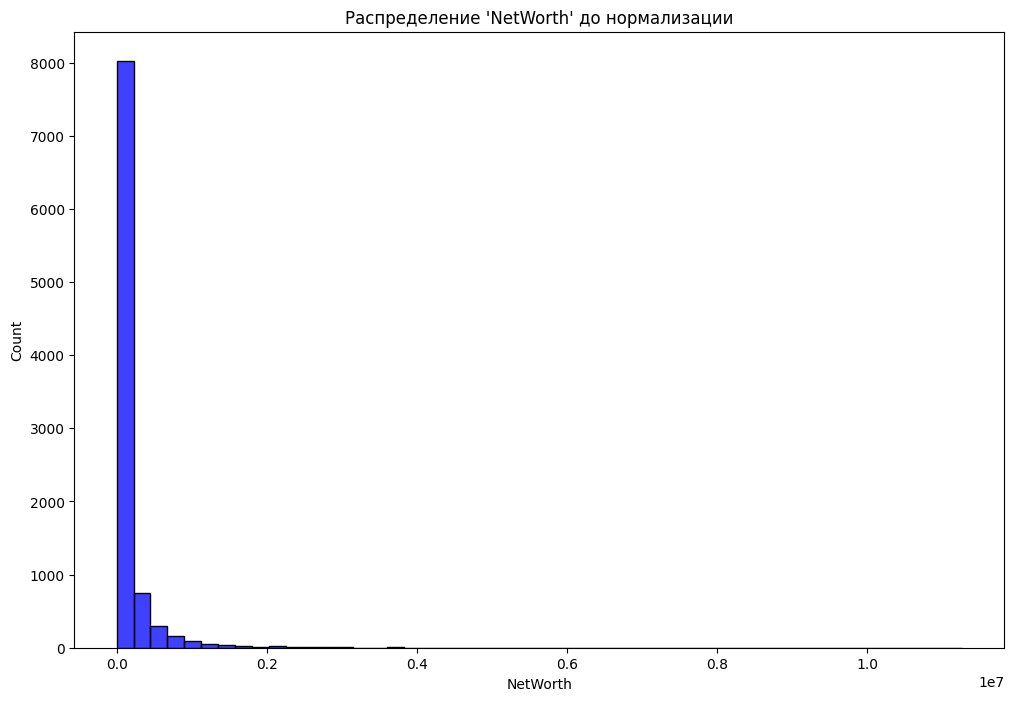

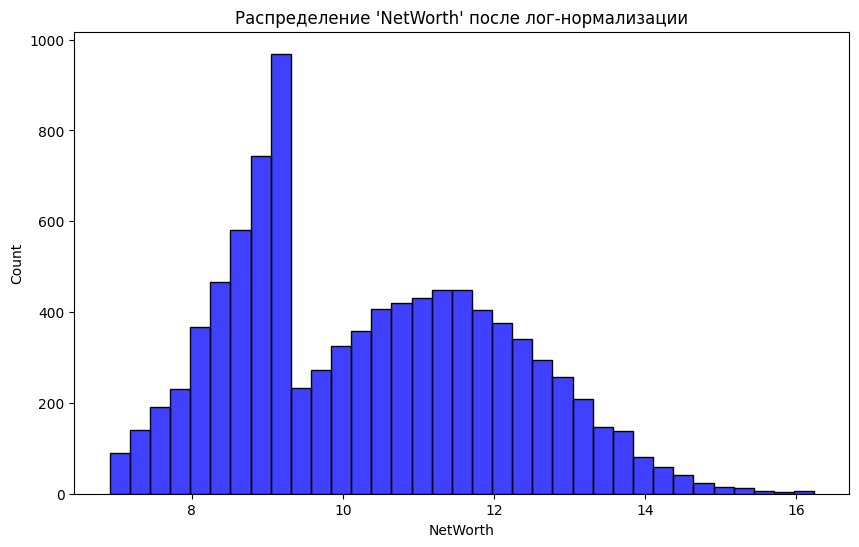

In [255]:
plt.figure(figsize=(12, 8))
sns.histplot(train_data['NetWorth'], color='blue', bins=50)
plt.title("Распределение 'NetWorth' до нормализации")
plt.show()

train_data['NetWorth'] = np.log1p(train_data['NetWorth'])
test_data['NetWorth'] = np.log1p(test_data['NetWorth'])

plt.figure(figsize=(10, 6))
sns.histplot(train_data['NetWorth'], color='blue')
plt.title("Распределение 'NetWorth' после лог-нормализации")
plt.show()

scaler_z = StandardScaler()
train_data['NetWorth'] = scaler_z.fit_transform(train_data[['NetWorth']])
test_data['NetWorth'] = scaler_z.fit_transform(test_data[['NetWorth']])

# TotalDebtToIncomeRatio

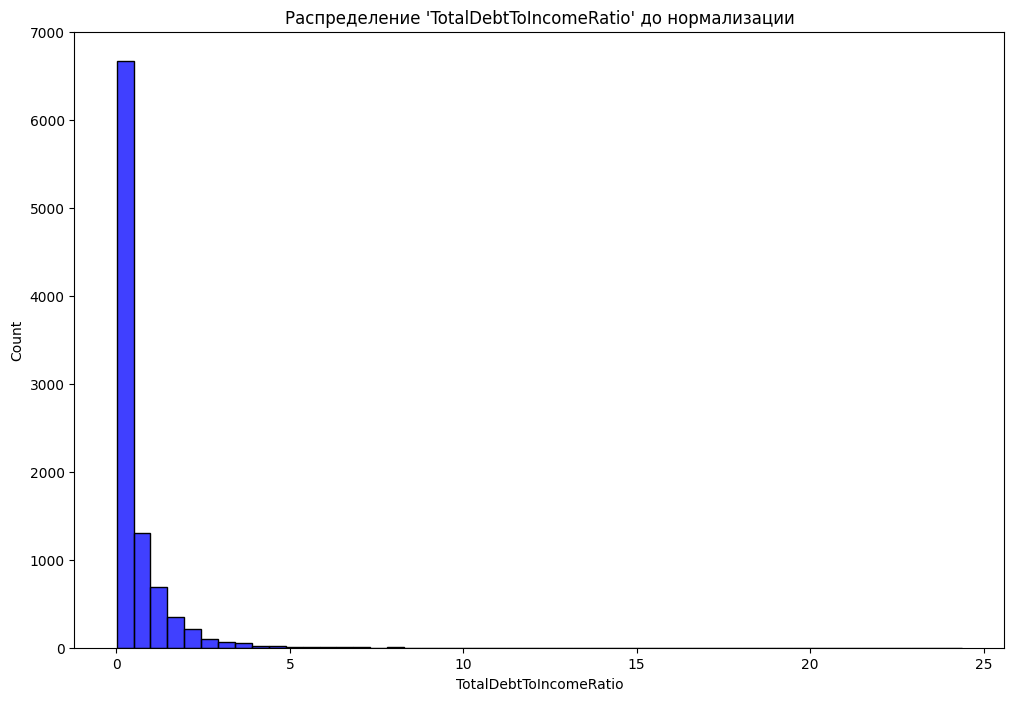

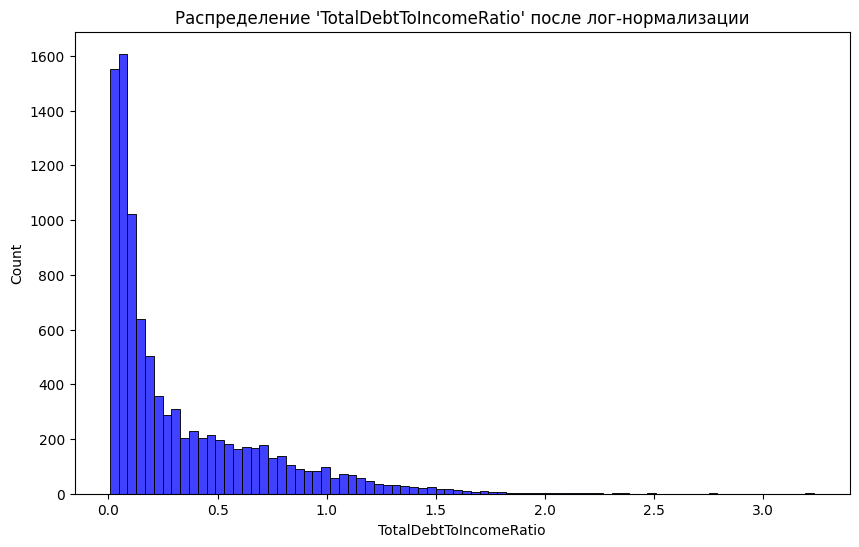

In [256]:
plt.figure(figsize=(12, 8))
sns.histplot(train_data['TotalDebtToIncomeRatio'], color='blue', bins=50)
plt.title("Распределение 'TotalDebtToIncomeRatio' до нормализации")
plt.show()

train_data['TotalDebtToIncomeRatio'] = np.log1p(train_data['TotalDebtToIncomeRatio'])
test_data['TotalDebtToIncomeRatio'] = np.log1p(test_data['TotalDebtToIncomeRatio'])

plt.figure(figsize=(10, 6))
sns.histplot(train_data['TotalDebtToIncomeRatio'], color='blue')
plt.title("Распределение 'TotalDebtToIncomeRatio' после лог-нормализации")
plt.show()

scaler_z = StandardScaler()
train_data['TotalDebtToIncomeRatio'] = scaler_z.fit_transform(train_data[['TotalDebtToIncomeRatio']])
test_data['TotalDebtToIncomeRatio'] = scaler_z.fit_transform(test_data[['TotalDebtToIncomeRatio']])

# RiskScore  
Используем способ определения выбросов, основанный на квартилях. Межквартильный размах определяется как разница между нижним (Q1) и верхним (Q3) квартилями. Выбросы определяются как значения, находящиеся за пределами 1,5 IQR от Q1 и Q3.  
Метод IQR основывается на распределении значений между первым и третьим квартилем (25% и 75%). Выбросами считаются значения, которые выходят за пределы 1.5×IQR.

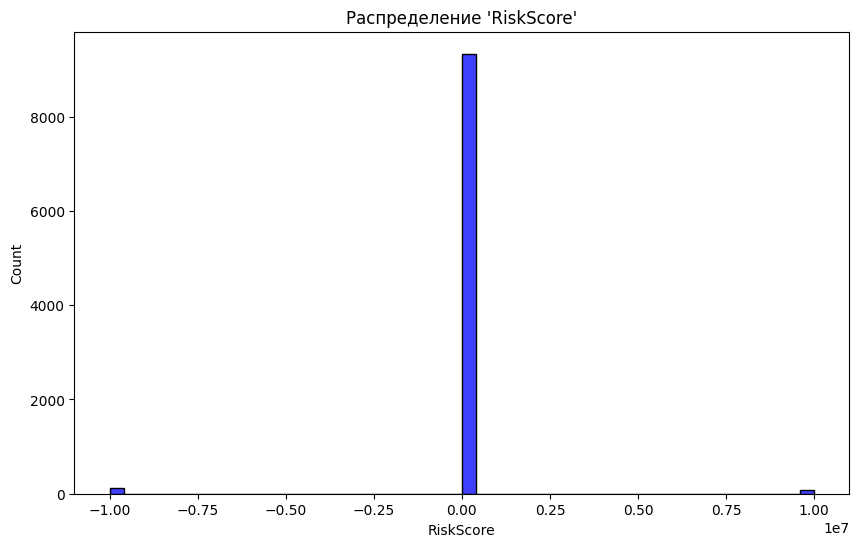

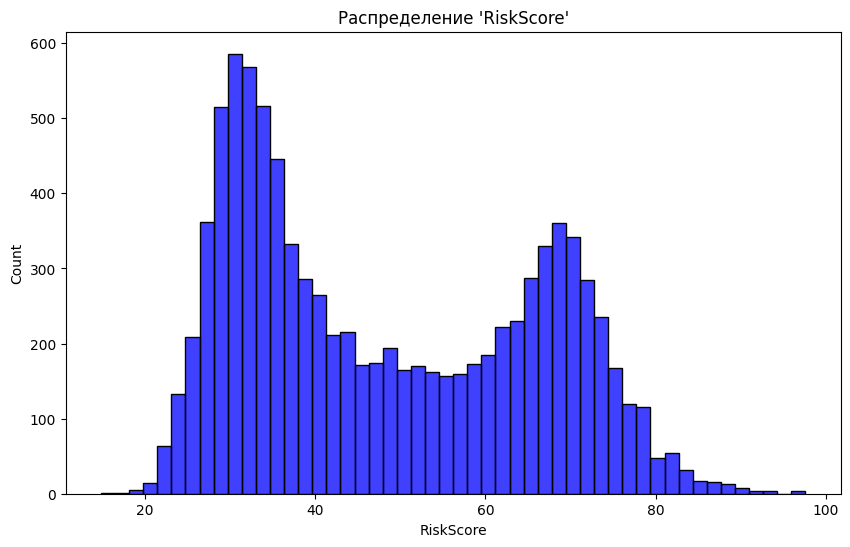

In [257]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['RiskScore'], color='blue', bins=50)
plt.title("Распределение 'RiskScore'")
plt.show()

Q1 = train_data['RiskScore'].quantile(0.25)
Q3 = train_data['RiskScore'].quantile(0.75)
IQR = Q3 - Q1  # Межквартильный размах

# Определение выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

train_data = train_data[(train_data['RiskScore'] >= lower_bound) & (train_data['RiskScore'] <= upper_bound)]

plt.figure(figsize=(10, 6))
sns.histplot(train_data['RiskScore'], color='blue', bins=50)
plt.title("Распределение 'RiskScore'")
plt.show()

# Обучение модели    


In [258]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# Разделение данных на признаки (X) и целевую переменную (Y)
X = train_data.drop(columns=['RiskScore'])  # Признаки из train_data
Y = train_data['RiskScore']  # Целевая переменная из train_data

# Разделение данных на тренировочные и тестовые выборки
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Стандартизация данных (обучаем только на тренировочных данных и применяем к тестовым)
X_train_scaled = X_train
X_test_scaled = X_test

# Создаем модели
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=0.001),
    'Lasso Regression': Lasso(alpha=0.001),
    'ElasticNet Regression': ElasticNet(alpha=0.001)
}

# Обучение и предсказание для каждой модели
for model_name, model in models.items():
    # Обучаем модель
    model.fit(X_train_scaled, Y_train)

    Y_pred = model.predict(X_test_scaled)

    # Оценка качества моделей
    mse = mean_squared_error(Y_test, Y_pred)
    r2 = r2_score(Y_test, Y_pred)

    print(f"Model: {model_name}")
    print(f"MSE: {mse}")
    print(f"R²: {r2}")
    print("-" * 30)


Model: Linear Regression
MSE: 16.244352683454157
R²: 0.9457518981092244
------------------------------
Model: Ridge Regression
MSE: 16.244356190973516
R²: 0.945751886395845
------------------------------
Model: Lasso Regression
MSE: 16.236920999100168
R²: 0.9457767162585168
------------------------------
Model: ElasticNet Regression
MSE: 16.25714736590626
R²: 0.9457091701993565
------------------------------


Посмотрев на результаты 4 моделей, выбрал ту, которая показала лучший результат - *Linear Regression*

In [259]:
X_test_final = test_data.drop(columns=['ID'])
# Предсказание для test_data
y_pred_final = models['Linear Regression'].predict(X_test_final)
# Создание файла submission с предсказаниями
submission = pd.DataFrame({ 'ID': test_data['ID'], 'RiskScore': y_pred_final })
submission.to_csv('submission.csv', index=False)